## Import libraries

In [1]:
import gc
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import featuretools as ft
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import QuantileTransformer

In [2]:
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.size'] = 12
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'

## Load source datasets

In [3]:
train_df = pd.read_csv("../input/mh-soccer-fever/train.csv")
print(f"train_df: {train_df.shape}")
train_df.head()

train_df: (7443, 21)


,season,date,league_id,league,Team 1,Team2,SPI1,SPI2,proj_score1,proj_score2,...,importance2,score1,score2,xg1,xg2,nsxg1,nsxg2,adj_score1,adj_score2,Outcome
0,2019,01/03/19,1979,Chinese Super League,Shandong Luneng,Guizhou Renhe,48.22,37.83,1.75,0.84,...,22.1,1.0,0.0,1.39,0.26,2.05,0.54,1.05,0.00,1
1,2019,01/03/19,1979,Chinese Super League,Shanghai Greenland,Shanghai SIPG,39.81,60.08,1.22,1.89,...,63.4,0.0,4.0,0.57,2.76,0.80,1.50,0.00,3.26,0
2,2019,01/03/19,1979,Chinese Super League,Guangzhou Evergrande,Tianjin Quanujian,65.59,39.99,2.58,0.62,...,28.8,3.0,0.0,0.49,0.45,1.05,0.75,3.15,0.00,1
3,2019,01/03/19,1979,Chinese Super League,Wuhan Zall,Beijing Guoan,32.25,54.82,1.10,1.79,...,58.9,0.0,1.0,1.12,0.97,1.51,0.94,0.00,1.05,0
4,2019,01/03/19,1979,Chinese Super League,Chongqing Lifan,Guangzhou RF,38.24,40.45,1.57,1.24,...,21.3,2.0,2.0,2.77,3.17,1.05,2.08,2.10,2.10,1


In [4]:
test_df = pd.read_csv("../input/mh-soccer-fever/test.csv")
print(f"test_df: {test_df.shape}")
test_df.head()

test_df: (4008, 20)


,season,date,league_id,league,Team 1,Team2,SPI1,SPI2,proj_score1,proj_score2,importance1,importance2,score1,score2,xg1,xg2,nsxg1,nsxg2,adj_score1,adj_score2
0,2021,14/12/21,2411,BPL,Arsenal,West Ham United,79.65,74.06,1.67,1.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021,14/12/21,2411,BPL,Brighton and Hove Albion,Wolverhampton,74.19,71.14,1.35,0.98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021,14/12/21,2411,BPL,Norwich City,Aston Villa,60.67,71.45,1.18,1.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021,14/12/21,2411,BPL,Leicester City,Tottenham Hotspur,76.88,79.06,1.52,1.44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021,14/12/21,2411,BPL,Brentford,Manchester United,63.53,85.58,0.95,1.92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Handle missing data

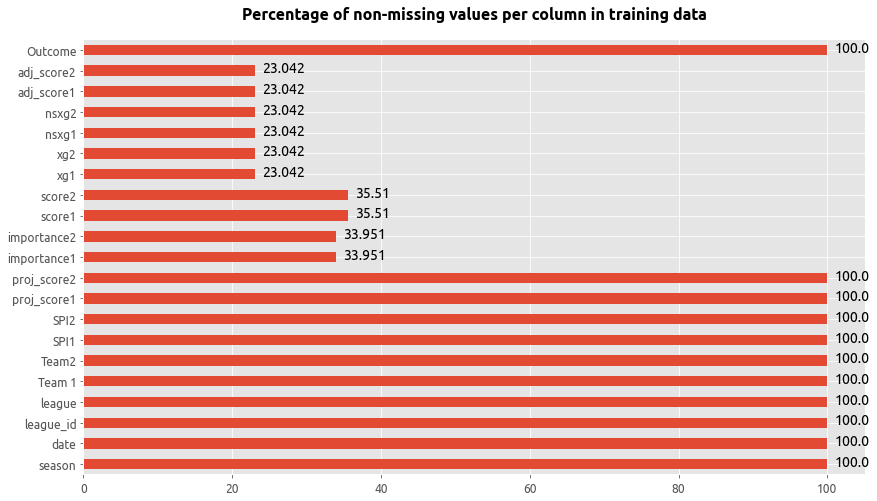

In [5]:
pct_df = pd.DataFrame(train_df.count() * 100 / len(train_df), 
                      columns=['Percent Non-Missing'])
pct_df['Percent Non-Missing'] = np.round(pct_df['Percent Non-Missing'], 3)

pct_df.plot(kind='barh', figsize=(14, 8), legend=False)
plt.title("Percentage of non-missing values per column in training data", pad=20)

for i, v in enumerate(pct_df['Percent Non-Missing']):
    plt.text(v + 1, i - 0.1, str(v), color='k', fontsize=14)

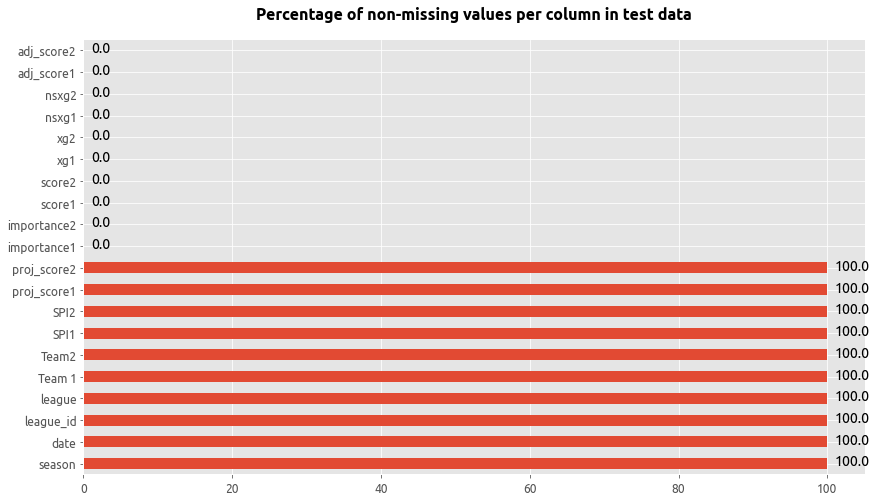

In [6]:
pct_df = pd.DataFrame(test_df.count() * 100 / len(test_df), 
                      columns=['Percent Non-Missing'])
pct_df['Percent Non-Missing'] = np.round(pct_df['Percent Non-Missing'], 3)

pct_df.plot(kind='barh', figsize=(14, 8), legend=False)
plt.title("Percentage of non-missing values per column in test data", pad=20)

for i, v in enumerate(pct_df['Percent Non-Missing']):
    plt.text(v + 1, i - 0.1, str(v), color='k', fontsize=14)

In [7]:
# Dropping columns having no value in test dataset
train_df.drop(['importance1','importance2','score1','score2',
               'xg1','xg2','nsxg1','nsxg2','adj_score1',
               'adj_score2'], axis=1, inplace=True)

test_df.drop(['importance1','importance2','score1','score2',
              'xg1','xg2','nsxg1','nsxg2','adj_score1',
              'adj_score2'], axis=1, inplace=True)

train_df.head()

,season,date,league_id,league,Team 1,Team2,SPI1,SPI2,proj_score1,proj_score2,Outcome
0,2019,01/03/19,1979,Chinese Super League,Shandong Luneng,Guizhou Renhe,48.22,37.83,1.75,0.84,1
1,2019,01/03/19,1979,Chinese Super League,Shanghai Greenland,Shanghai SIPG,39.81,60.08,1.22,1.89,0
2,2019,01/03/19,1979,Chinese Super League,Guangzhou Evergrande,Tianjin Quanujian,65.59,39.99,2.58,0.62,1
3,2019,01/03/19,1979,Chinese Super League,Wuhan Zall,Beijing Guoan,32.25,54.82,1.10,1.79,0
4,2019,01/03/19,1979,Chinese Super League,Chongqing Lifan,Guangzhou RF,38.24,40.45,1.57,1.24,1


## Examine target data and features correlation

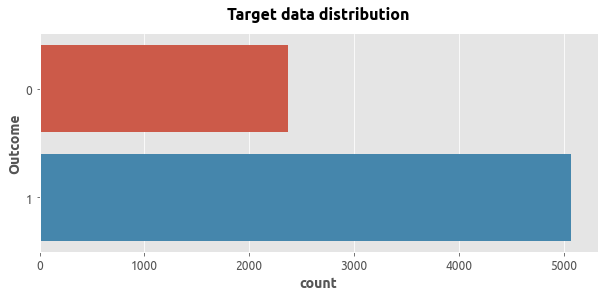

In [8]:
plt.figure(figsize=(10, 4))
sns.countplot(y='Outcome', data=train_df)
plt.title("Target data distribution", pad=15);

### season

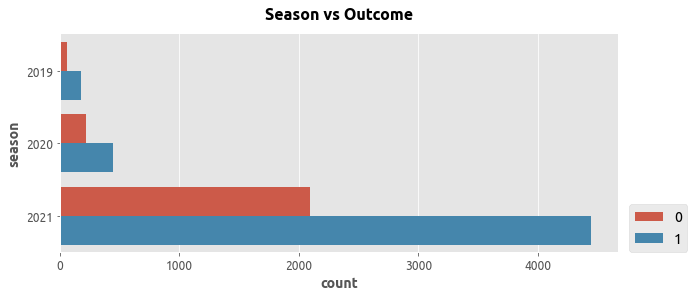

In [9]:
plt.figure(figsize=(10, 4))
sns.countplot(y='season', hue='Outcome', data=train_df)
plt.title("Season vs Outcome", pad=15)
plt.legend(loc=(1.02, 0));

### date

In [10]:
train_df['year'] = train_df['date'].map(lambda x: pd.to_datetime(x).year)
train_df['quarter'] = train_df['date'].map(lambda x: pd.to_datetime(x).quarter)
train_df['month'] = train_df['date'].map(lambda x: pd.to_datetime(x).month)
train_df['week'] = train_df['date'].map(lambda x: pd.to_datetime(x).week)
train_df['day_year'] = train_df['date'].map(lambda x: pd.to_datetime(x).dayofyear)
train_df['day_month'] = train_df['date'].map(lambda x: pd.to_datetime(x).day)
train_df['day_week'] = train_df['date'].map(lambda x: pd.to_datetime(x).dayofweek)
train_df['day_weekend'] = np.where(train_df['day_week'].isin([5,6]),1,0)
train_df['year_eq_season'] = train_df.apply(lambda x: 1 if x['year']==x['season'] else 0, axis=1)
train_df.drop(['date'], axis=1, inplace=True)
train_df.head()

,season,league_id,league,Team 1,Team2,SPI1,SPI2,proj_score1,proj_score2,Outcome,year,quarter,month,week,day_year,day_month,day_week,day_weekend,year_eq_season
0,2019,1979,Chinese Super League,Shandong Luneng,Guizhou Renhe,48.22,37.83,1.75,0.84,1,2019,1,1,1,3,3,3,0,1
1,2019,1979,Chinese Super League,Shanghai Greenland,Shanghai SIPG,39.81,60.08,1.22,1.89,0,2019,1,1,1,3,3,3,0,1
2,2019,1979,Chinese Super League,Guangzhou Evergrande,Tianjin Quanujian,65.59,39.99,2.58,0.62,1,2019,1,1,1,3,3,3,0,1
3,2019,1979,Chinese Super League,Wuhan Zall,Beijing Guoan,32.25,54.82,1.10,1.79,0,2019,1,1,1,3,3,3,0,1
4,2019,1979,Chinese Super League,Chongqing Lifan,Guangzhou RF,38.24,40.45,1.57,1.24,1,2019,1,1,1,3,3,3,0,1


In [11]:
test_df['year'] = test_df['date'].map(lambda x: pd.to_datetime(x).year)
test_df['quarter'] = test_df['date'].map(lambda x: pd.to_datetime(x).quarter)
test_df['month'] = test_df['date'].map(lambda x: pd.to_datetime(x).month)
test_df['week'] = test_df['date'].map(lambda x: pd.to_datetime(x).week)
test_df['day_year'] = test_df['date'].map(lambda x: pd.to_datetime(x).dayofyear)
test_df['day_month'] = test_df['date'].map(lambda x: pd.to_datetime(x).day)
test_df['day_week'] = test_df['date'].map(lambda x: pd.to_datetime(x).dayofweek)
test_df['day_weekend'] = np.where(test_df['day_week'].isin([5,6]),1,0)
test_df['year_eq_season'] = test_df.apply(lambda x: 1 if x['year']==x['season'] else 0, axis=1)
test_df.drop(['date'], axis=1, inplace=True)
test_df.head()

,season,league_id,league,Team 1,Team2,SPI1,SPI2,proj_score1,proj_score2,year,quarter,month,week,day_year,day_month,day_week,day_weekend,year_eq_season
0,2021,2411,BPL,Arsenal,West Ham United,79.65,74.06,1.67,1.19,2021,4,12,50,348,14,1,0,1
1,2021,2411,BPL,Brighton and Hove Albion,Wolverhampton,74.19,71.14,1.35,0.98,2021,4,12,50,348,14,1,0,1
2,2021,2411,BPL,Norwich City,Aston Villa,60.67,71.45,1.18,1.49,2021,4,12,50,348,14,1,0,1
3,2021,2411,BPL,Leicester City,Tottenham Hotspur,76.88,79.06,1.52,1.44,2021,4,12,50,348,14,1,0,1
4,2021,2411,BPL,Brentford,Manchester United,63.53,85.58,0.95,1.92,2021,4,12,50,348,14,1,0,1


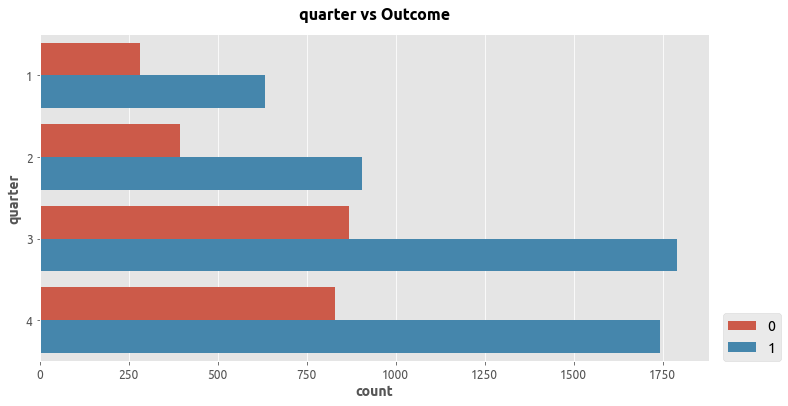

In [12]:
plt.figure(figsize=(12, 6))
sns.countplot(y='quarter', hue='Outcome', data=train_df)
plt.title("quarter vs Outcome", pad=15)
plt.legend(loc=(1.02, 0));

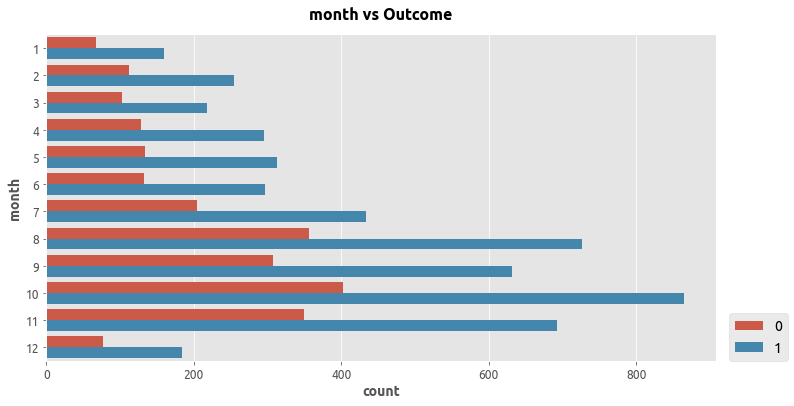

In [13]:
plt.figure(figsize=(12, 6))
sns.countplot(y='month', hue='Outcome', data=train_df)
plt.title("month vs Outcome", pad=15)
plt.legend(loc=(1.02, 0));

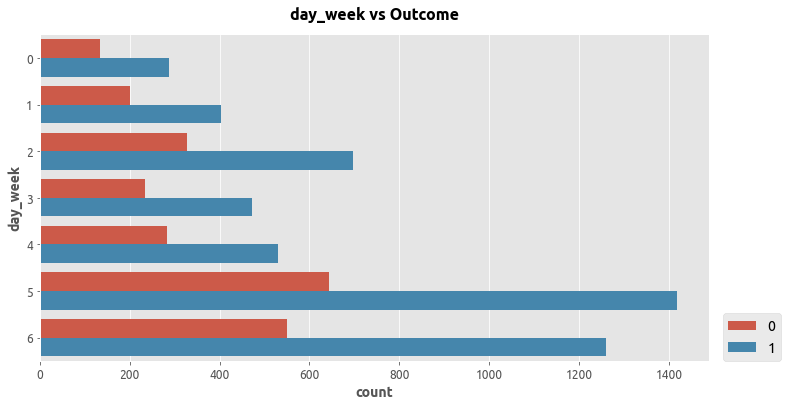

In [14]:
plt.figure(figsize=(12, 6))
sns.countplot(y='day_week', hue='Outcome', data=train_df)
plt.title("day_week vs Outcome", pad=15)
plt.legend(loc=(1.02, 0));

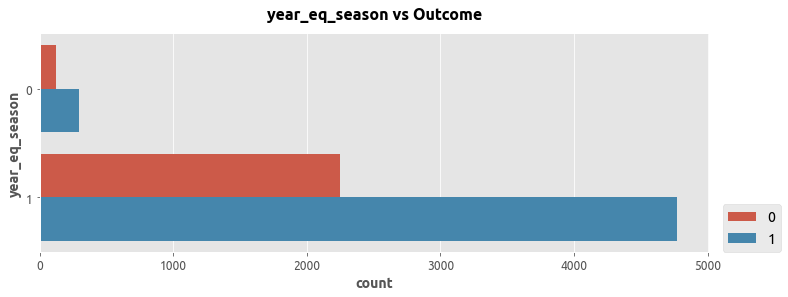

In [15]:
plt.figure(figsize=(12, 4))
sns.countplot(y='year_eq_season', hue='Outcome', data=train_df)
plt.title("year_eq_season vs Outcome", pad=15)
plt.legend(loc=(1.02, 0));

### league and team

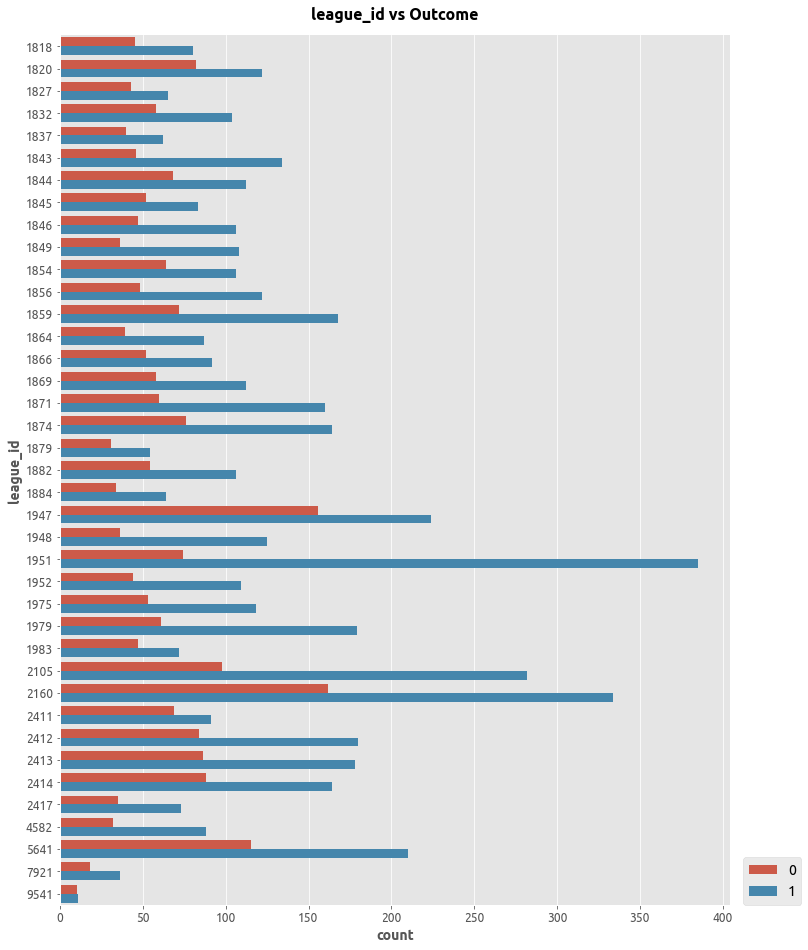

In [16]:
plt.figure(figsize=(12, 16))
sns.countplot(y='league_id', hue='Outcome', data=train_df)
plt.title("league_id vs Outcome", pad=15)
plt.legend(loc=(1.02, 0));

In [17]:
encode_cols = ['league','Team 1','Team2']

for col in encode_cols:
    le = LabelEncoder().fit(train_df[col].append(test_df[col]))
    train_df[col] = le.transform(train_df[col])
    test_df[col] = le.transform(test_df[col])

train_df.drop(['league_id'], axis=1, inplace=True)
test_df.drop(['league_id'], axis=1, inplace=True)
train_df.head()

,season,league,Team 1,Team2,SPI1,SPI2,proj_score1,proj_score2,Outcome,year,quarter,month,week,day_year,day_month,day_week,day_weekend,year_eq_season
0,2019,6,531,262,48.22,37.83,1.75,0.84,1,2019,1,1,1,3,3,3,0,1
1,2019,6,532,533,39.81,60.08,1.22,1.89,0,2019,1,1,1,3,3,3,0,1
2,2019,6,258,589,65.59,39.99,2.58,0.62,1,2019,1,1,1,3,3,3,0,1
3,2019,6,649,73,32.25,54.82,1.10,1.79,0,2019,1,1,1,3,3,3,0,1
4,2019,6,138,259,38.24,40.45,1.57,1.24,1,2019,1,1,1,3,3,3,0,1


### SPI

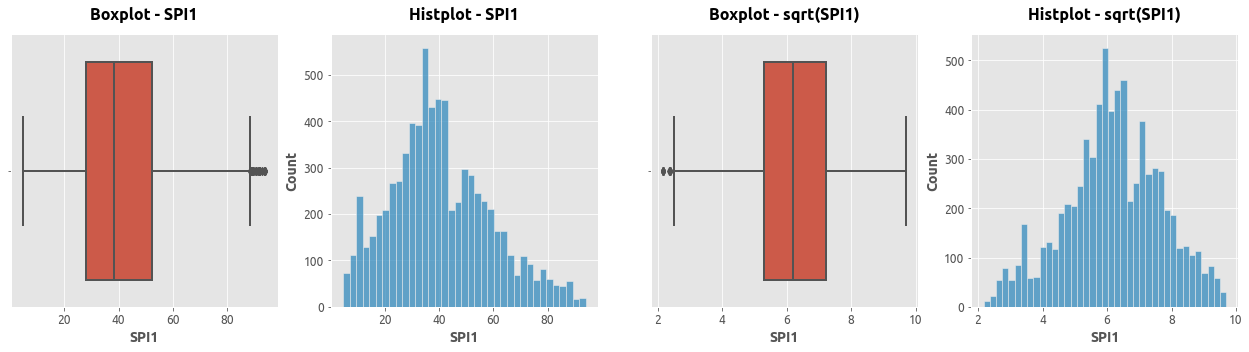

In [18]:
x1 = train_df['SPI1']
x2 = np.sqrt(x1)

_, ax = plt.subplots(1, 4, figsize=(22, 5))
sns.boxplot(x=x1, ax=ax[0]);
sns.histplot(x=x1, ax=ax[1]);
sns.boxplot(x=x2, ax=ax[2]);
sns.histplot(x=x2, ax=ax[3]);
ax[0].set_title("Boxplot - SPI1", pad=15);
ax[1].set_title("Histplot - SPI1", pad=15);
ax[2].set_title("Boxplot - sqrt(SPI1)", pad=15);
ax[3].set_title("Histplot - sqrt(SPI1)", pad=15);

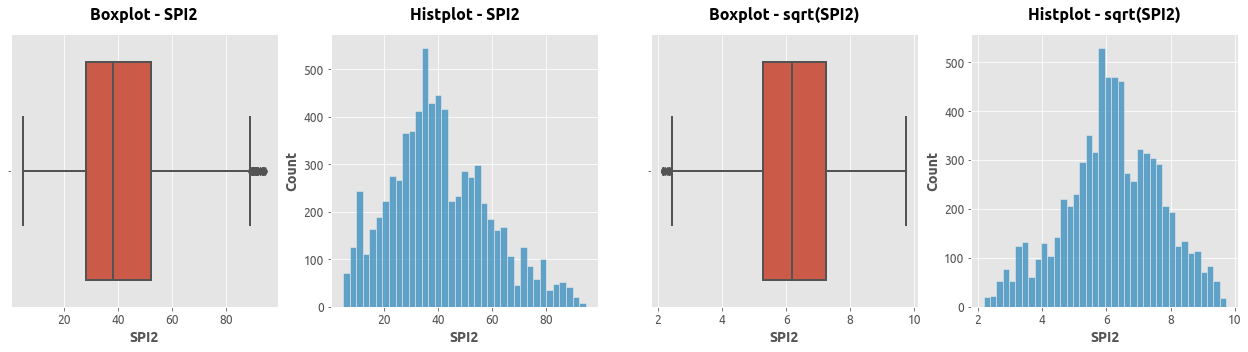

In [19]:
x1 = train_df['SPI2']
x2 = np.sqrt(x1)

_, ax = plt.subplots(1, 4, figsize=(22, 5))
sns.boxplot(x=x1, ax=ax[0]);
sns.histplot(x=x1, ax=ax[1]);
sns.boxplot(x=x2, ax=ax[2]);
sns.histplot(x=x2, ax=ax[3]);
ax[0].set_title("Boxplot - SPI2", pad=15);
ax[1].set_title("Histplot - SPI2", pad=15);
ax[2].set_title("Boxplot - sqrt(SPI2)", pad=15);
ax[3].set_title("Histplot - sqrt(SPI2)", pad=15);

In [20]:
train_df['SPI1'] = np.sqrt(train_df['SPI1'])
train_df['SPI2'] = np.sqrt(train_df['SPI2'])

test_df['SPI1'] = np.sqrt(test_df['SPI1'])
test_df['SPI2'] = np.sqrt(test_df['SPI2'])

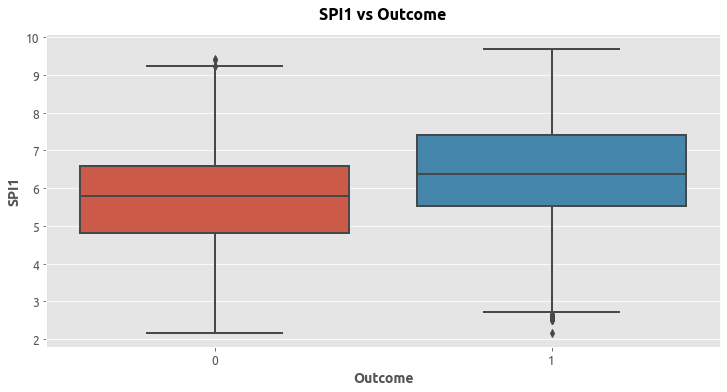

In [21]:
sns.catplot(x="Outcome", y="SPI1", data=train_df, kind="box", height=5, aspect=2)
plt.title("SPI1 vs Outcome", pad=15);

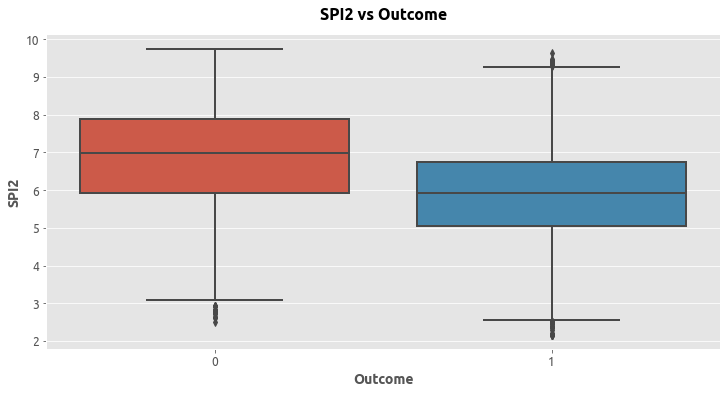

In [22]:
sns.catplot(x="Outcome", y="SPI2", data=train_df, kind="box", height=5, aspect=2)
plt.title("SPI2 vs Outcome", pad=15);

In [23]:
train_df['SPI_Mean'] = (train_df['SPI1'] + train_df['SPI2'])/2.0
train_df['SPI_Diff'] = np.abs(train_df['SPI1'] - train_df['SPI2'])
train_df['SPI1_Ratio'] = train_df.apply(lambda x: x['SPI1']/(x['SPI1'] + x['SPI2']), axis=1)
train_df['SPI2_Ratio'] = train_df.apply(lambda x: x['SPI2']/(x['SPI1'] + x['SPI2']), axis=1)
train_df['SPI_sqrt'] = train_df.apply(lambda x: np.sqrt((x['SPI1']**2)+(x['SPI2']**2)), axis=1)
train_df['SPI_HM'] = train_df.apply(lambda x: (x['SPI1'] * x['SPI2'])/(x['SPI1'] + x['SPI2']), axis=1)

In [24]:
test_df['SPI_Mean'] = (test_df['SPI1'] + test_df['SPI2'])/2.0
test_df['SPI_Diff'] = np.abs(test_df['SPI1'] - test_df['SPI2'])
test_df['SPI1_Ratio'] = test_df.apply(lambda x: x['SPI1']/(x['SPI1'] + x['SPI2']), axis=1)
test_df['SPI2_Ratio'] = test_df.apply(lambda x: x['SPI2']/(x['SPI1'] + x['SPI2']), axis=1)
test_df['SPI_sqrt'] = test_df.apply(lambda x: np.sqrt((x['SPI1']**2)+(x['SPI2']**2)), axis=1)
test_df['SPI_HM'] = test_df.apply(lambda x: (x['SPI1'] * x['SPI2'])/(x['SPI1'] + x['SPI2']), axis=1)

### proj_score

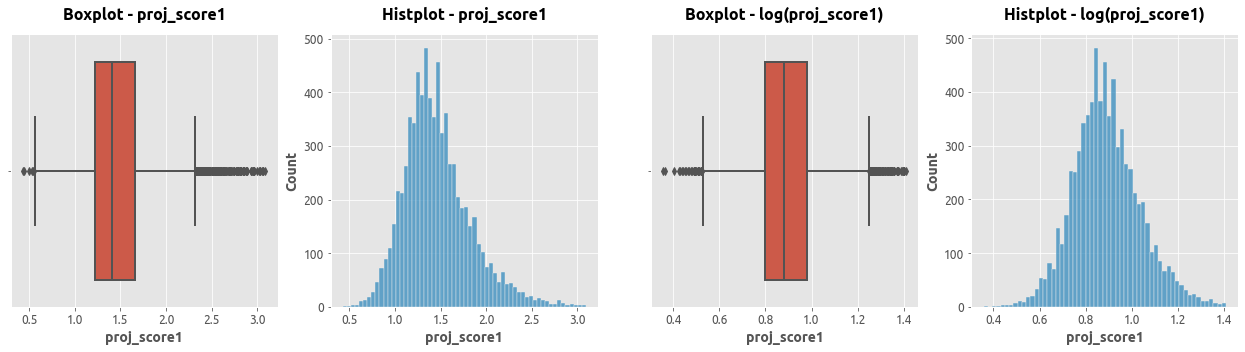

In [25]:
x1 = train_df[train_df['proj_score1']<3.5]['proj_score1']
x2 = np.log1p(x1)

_, ax = plt.subplots(1, 4, figsize=(22, 5))
sns.boxplot(x=x1, ax=ax[0]);
sns.histplot(x=x1, ax=ax[1]);
sns.boxplot(x=x2, ax=ax[2]);
sns.histplot(x=x2, ax=ax[3]);
ax[0].set_title("Boxplot - proj_score1", pad=15);
ax[1].set_title("Histplot - proj_score1", pad=15);
ax[2].set_title("Boxplot - log(proj_score1)", pad=15);
ax[3].set_title("Histplot - log(proj_score1)", pad=15);

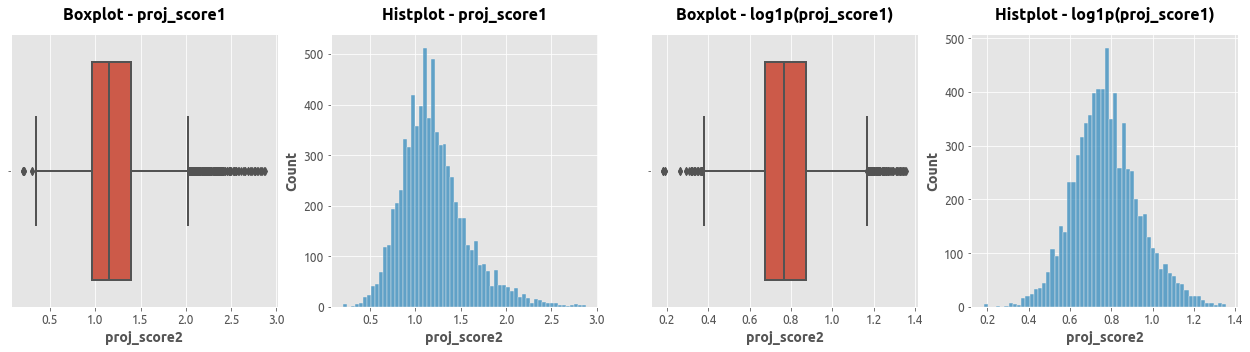

In [26]:
x1 = train_df[train_df['proj_score2'] < 3]['proj_score2']
x2 = np.log1p(x1)

_, ax = plt.subplots(1, 4, figsize=(22, 5))
sns.boxplot(x=x1, ax=ax[0]);
sns.histplot(x=x1, ax=ax[1]);
sns.boxplot(x=x2, ax=ax[2]);
sns.histplot(x=x2, ax=ax[3]);
ax[0].set_title("Boxplot - proj_score1", pad=15);
ax[1].set_title("Histplot - proj_score1", pad=15);
ax[2].set_title("Boxplot - log1p(proj_score1)", pad=15);
ax[3].set_title("Histplot - log1p(proj_score1)", pad=15);

In [27]:
train_df = train_df[train_df['proj_score1'] < 3.5].copy()
train_df = train_df[train_df['proj_score2'] < 3].copy()

train_df['proj_score1'] = np.log1p(train_df['proj_score1'])
train_df['proj_score2'] = np.log1p(train_df['proj_score2'])

test_df['proj_score1'] = np.log1p(test_df['proj_score1'])
test_df['proj_score2'] = np.log1p(test_df['proj_score2'])

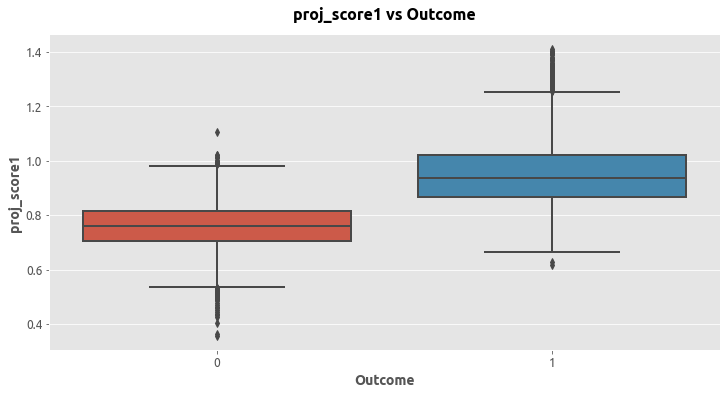

In [28]:
sns.catplot(x="Outcome", y="proj_score1", data=train_df, kind="box", height=5, aspect=2)
plt.title("proj_score1 vs Outcome", pad=15);

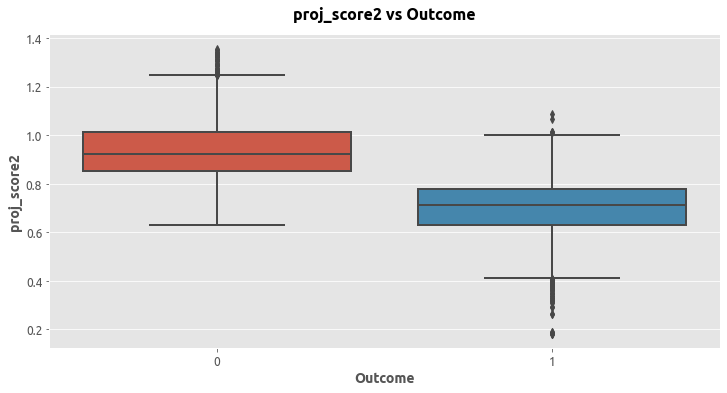

In [29]:
sns.catplot(x="Outcome", y="proj_score2", data=train_df, kind="box", height=5, aspect=2)
plt.title("proj_score2 vs Outcome", pad=15);

In [30]:
train_df['proj_score_Mean'] = (train_df['proj_score1'] + train_df['proj_score2'])/2.0
train_df['proj_score_Diff'] = np.abs(train_df['proj_score1'] - train_df['proj_score2'])
train_df['proj_score1_Ratio'] = train_df.apply(lambda x: x['proj_score1']/(x['proj_score1'] + x['proj_score2']), axis=1)
train_df['proj_score2_Ratio'] = train_df.apply(lambda x: x['proj_score2']/(x['proj_score1'] + x['proj_score2']), axis=1)
train_df['proj_score_sqrt'] = train_df.apply(lambda x: np.sqrt((x['proj_score1']**2)+(x['proj_score2']**2)), axis=1)
train_df['proj_score_HM'] = train_df.apply(lambda x: (x['proj_score1'] * x['proj_score2'])/(x['proj_score1'] + x['proj_score2']), axis=1)

In [31]:
test_df['proj_score_Mean'] = (test_df['proj_score1'] + test_df['proj_score2'])/2.0
test_df['proj_score_Diff'] = np.abs(test_df['proj_score1'] - test_df['proj_score2'])
test_df['proj_score1_Ratio'] = test_df.apply(lambda x: x['proj_score1']/(x['proj_score1'] + x['proj_score2']), axis=1)
test_df['proj_score2_Ratio'] = test_df.apply(lambda x: x['proj_score2']/(x['proj_score1'] + x['proj_score2']), axis=1)
test_df['proj_score_sqrt'] = test_df.apply(lambda x: np.sqrt((x['proj_score1']**2)+(x['proj_score2']**2)), axis=1)
test_df['proj_score_HM'] = test_df.apply(lambda x: (x['proj_score1'] * x['proj_score2'])/(x['proj_score1'] + x['proj_score2']), axis=1)

### Features Correlation

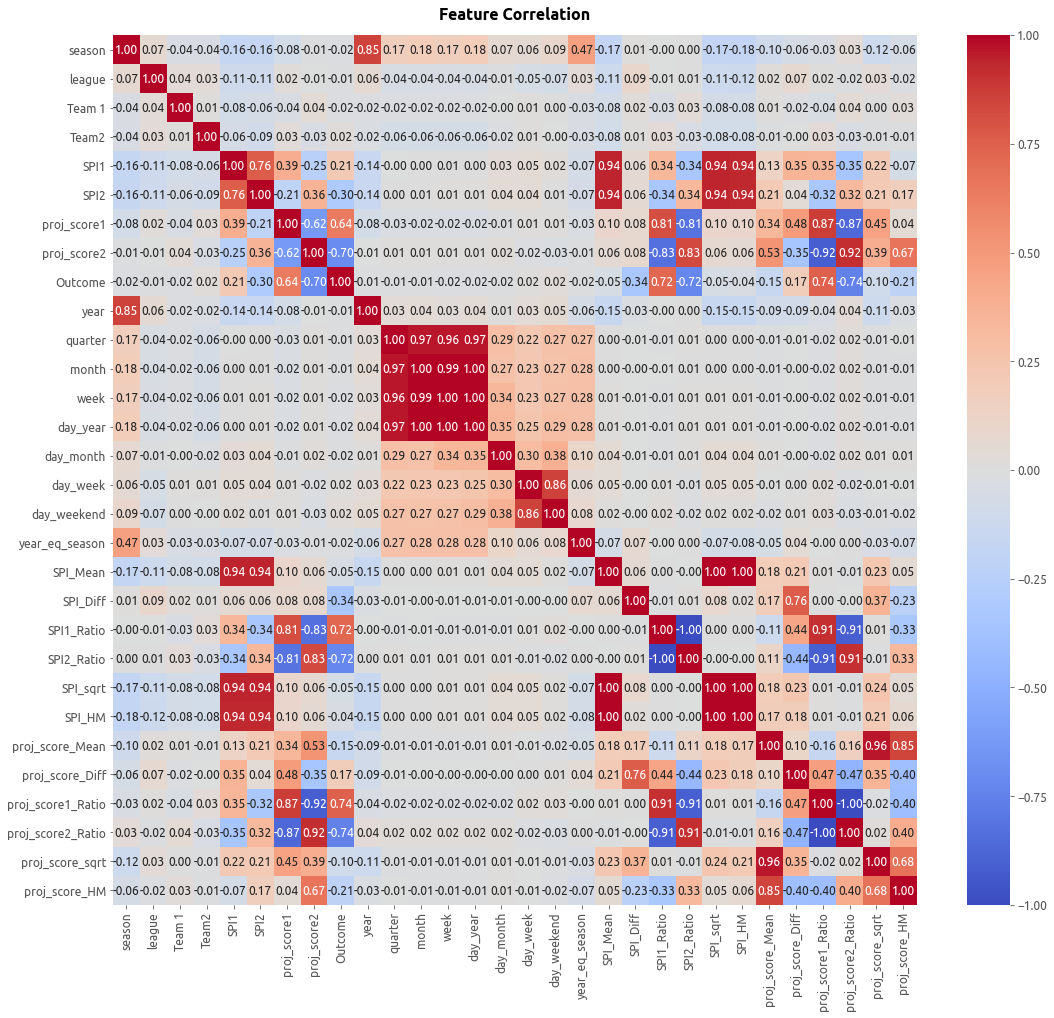

In [32]:
plt.subplots(1,1,figsize=(18, 16))
sns.heatmap(train_df.corr(), annot=True, fmt='.2f', cmap="coolwarm")
plt.title("Feature Correlation", pad=15);

## Extract target label

In [33]:
train_y = train_df['Outcome']
train_df.drop(['Outcome'], inplace=True, axis=1)
print("train_y: {}".format(train_y.shape))

train_y: (7441,)


## Group features

In [34]:
combined_df = train_df.append(test_df, sort=False, ignore_index=True)
combined_df.head()

,season,league,Team 1,Team2,SPI1,SPI2,proj_score1,proj_score2,year,quarter,...,SPI1_Ratio,SPI2_Ratio,SPI_sqrt,SPI_HM,proj_score_Mean,proj_score_Diff,proj_score1_Ratio,proj_score2_Ratio,proj_score_sqrt,proj_score_HM
0,2019,6,531,262,6.944062,6.150610,1.011601,0.609766,2019,1,...,0.530297,0.469703,9.276314,3.261648,0.810683,0.401835,0.623919,0.376081,1.181165,0.380444
1,2019,6,532,533,6.309517,7.751129,0.797507,1.061257,2019,1,...,0.448736,0.551264,9.994498,3.478210,0.929382,0.263749,0.429052,0.570948,1.327510,0.455335
2,2019,6,258,589,8.098765,6.323765,1.275363,0.482426,2019,1,...,0.561536,0.438464,10.275213,3.551020,0.878894,0.792937,0.725549,0.274451,1.363556,0.350024
3,2019,6,649,73,5.678908,7.404053,0.741937,1.026042,2019,1,...,0.434069,0.565931,9.331131,3.213870,0.883989,0.284104,0.419653,0.580347,1.266188,0.430581
4,2019,6,138,259,6.183850,6.360031,0.943906,0.806476,2019,1,...,0.492977,0.507023,8.870738,3.135352,0.875191,0.137430,0.539257,0.460743,1.241516,0.434898


In [35]:
temp = combined_df.groupby(['league']).agg({
    'Team 1': ['count'], 
    'Team2': ['count'], 
    'SPI1': ['mean','std','sum'],
    'SPI2': ['mean','std','sum'],
    'proj_score1': ['mean','std','sum'],
    'proj_score2': ['mean','std','sum'],
    'SPI_Mean': ['mean','std'],
    'SPI_Diff': ['mean','std','sum'],
    'SPI1_Ratio': ['mean','std'],
    'SPI2_Ratio': ['mean','std'],
    'SPI_sqrt': ['mean','std','sum'],
    'proj_score_Mean': ['mean','std'],
    'proj_score_Diff': ['mean','std','sum'],
    'proj_score1_Ratio': ['mean','std'],
    'proj_score2_Ratio': ['mean','std'],
    'proj_score_sqrt': ['mean','std','sum'],
    'SPI_HM': ['mean','std','sum'],
    'proj_score_HM': ['mean','std','sum']
})
temp.columns = ['f1_'+'_'.join(x) for x in temp.columns]
combined_df = pd.merge(combined_df, temp, on=['league'], how='left', sort=False)

del temp
gc.collect()

combined_df.head()

,season,league,Team 1,Team2,SPI1,SPI2,proj_score1,proj_score2,year,quarter,...,f1_proj_score2_Ratio_std,f1_proj_score_sqrt_mean,f1_proj_score_sqrt_std,f1_proj_score_sqrt_sum,f1_SPI_HM_mean,f1_SPI_HM_std,f1_SPI_HM_sum,f1_proj_score_HM_mean,f1_proj_score_HM_std,f1_proj_score_HM_sum
0,2019,6,531,262,6.944062,6.150610,1.011601,0.609766,2019,1,...,0.090782,1.231907,0.083657,295.657748,3.231427,0.249645,775.542444,0.408686,0.043531,98.08467
1,2019,6,532,533,6.309517,7.751129,0.797507,1.061257,2019,1,...,0.090782,1.231907,0.083657,295.657748,3.231427,0.249645,775.542444,0.408686,0.043531,98.08467
2,2019,6,258,589,8.098765,6.323765,1.275363,0.482426,2019,1,...,0.090782,1.231907,0.083657,295.657748,3.231427,0.249645,775.542444,0.408686,0.043531,98.08467
3,2019,6,649,73,5.678908,7.404053,0.741937,1.026042,2019,1,...,0.090782,1.231907,0.083657,295.657748,3.231427,0.249645,775.542444,0.408686,0.043531,98.08467
4,2019,6,138,259,6.183850,6.360031,0.943906,0.806476,2019,1,...,0.090782,1.231907,0.083657,295.657748,3.231427,0.249645,775.542444,0.408686,0.043531,98.08467


In [36]:
temp = combined_df.groupby(['Team 1']).agg({
    'SPI1': ['mean','std','sum'],
    'SPI2': ['mean','std','sum'],
    'proj_score1': ['mean','std','sum'],
    'proj_score2': ['mean','std','sum'],
    'SPI_Mean': ['mean','std'],
    'SPI_Diff': ['mean','std','sum'],
    'SPI1_Ratio': ['mean','std'],
    'SPI2_Ratio': ['mean','std'],
    'SPI_sqrt': ['mean','std','sum'],
    'proj_score_Mean': ['mean','std'],
    'proj_score_Diff': ['mean','std','sum'],
    'proj_score1_Ratio': ['mean','std'],
    'proj_score2_Ratio': ['mean','std'],
    'proj_score_sqrt': ['mean','std','sum'],
    'SPI_HM': ['mean','std','sum'],
    'proj_score_HM': ['mean','std','sum']
})
temp.columns = ['f2_'+'_'.join(x) for x in temp.columns]
combined_df = pd.merge(combined_df, temp, on=['Team 1'], how='left', sort=False)

del temp
gc.collect()

combined_df.head()

,season,league,Team 1,Team2,SPI1,SPI2,proj_score1,proj_score2,year,quarter,...,f2_proj_score2_Ratio_std,f2_proj_score_sqrt_mean,f2_proj_score_sqrt_std,f2_proj_score_sqrt_sum,f2_SPI_HM_mean,f2_SPI_HM_std,f2_SPI_HM_sum,f2_proj_score_HM_mean,f2_proj_score_HM_std,f2_proj_score_HM_sum
0,2019,6,531,262,6.944062,6.150610,1.011601,0.609766,2019,1,...,0.065458,1.248111,0.057007,18.721659,3.374152,0.215059,50.612286,0.416846,0.032471,6.252689
1,2019,6,532,533,6.309517,7.751129,0.797507,1.061257,2019,1,...,0.058867,1.241710,0.076820,18.625652,3.194235,0.178842,47.913525,0.429413,0.030372,6.441188
2,2019,6,258,589,8.098765,6.323765,1.275363,0.482426,2019,1,...,0.078577,1.313348,0.063974,19.700227,3.547845,0.208342,53.217678,0.355944,0.064360,5.339165
3,2019,6,649,73,5.678908,7.404053,0.741937,1.026042,2019,1,...,0.060637,1.183569,0.088171,17.753531,3.098169,0.141965,46.472536,0.410011,0.032815,6.150162
4,2019,6,138,259,6.183850,6.360031,0.943906,0.806476,2019,1,...,0.059360,1.191867,0.047576,17.878000,3.156058,0.163161,47.340868,0.413103,0.018043,6.196548


In [37]:
temp = combined_df.groupby(['Team2']).agg({
    'SPI1': ['mean','std','sum'],
    'SPI2': ['mean','std','sum'],
    'proj_score1': ['mean','std','sum'],
    'proj_score2': ['mean','std','sum'],
    'SPI_Mean': ['mean','std'],
    'SPI_Diff': ['mean','std','sum'],
    'SPI1_Ratio': ['mean','std'],
    'SPI2_Ratio': ['mean','std'],
    'SPI_sqrt': ['mean','std','sum'],
    'proj_score_Mean': ['mean','std'],
    'proj_score_Diff': ['mean','std','sum'],
    'proj_score1_Ratio': ['mean','std'],
    'proj_score2_Ratio': ['mean','std'],
    'proj_score_sqrt': ['mean','std','sum'],
    'SPI_HM': ['mean','std','sum'],
    'proj_score_HM': ['mean','std','sum']
})
temp.columns = ['f3_'+'_'.join(x) for x in temp.columns]
combined_df = pd.merge(combined_df, temp, on=['Team2'], how='left', sort=False)

del temp
gc.collect()

combined_df.head()

,season,league,Team 1,Team2,SPI1,SPI2,proj_score1,proj_score2,year,quarter,...,f3_proj_score2_Ratio_std,f3_proj_score_sqrt_mean,f3_proj_score_sqrt_std,f3_proj_score_sqrt_sum,f3_SPI_HM_mean,f3_SPI_HM_std,f3_SPI_HM_sum,f3_proj_score_HM_mean,f3_proj_score_HM_std,f3_proj_score_HM_sum
0,2019,6,531,262,6.944062,6.150610,1.011601,0.609766,2019,1,...,0.090559,1.185491,0.080078,17.782371,2.975688,0.197267,44.635315,0.361017,0.061446,5.415251
1,2019,6,532,533,6.309517,7.751129,0.797507,1.061257,2019,1,...,0.057889,1.242961,0.072633,18.644415,3.480141,0.207222,52.202120,0.422946,0.030052,6.344197
2,2019,6,258,589,8.098765,6.323765,1.275363,0.482426,2019,1,...,0.074623,1.222629,0.075944,18.339432,3.099036,0.182593,46.485537,0.398529,0.042743,5.977937
3,2019,6,649,73,5.678908,7.404053,0.741937,1.026042,2019,1,...,0.052423,1.263965,0.069294,18.959481,3.475579,0.215382,52.133678,0.431933,0.021939,6.478998
4,2019,6,138,259,6.183850,6.360031,0.943906,0.806476,2019,1,...,0.060695,1.383726,0.061907,20.755895,3.168635,0.247854,47.529527,0.465313,0.030913,6.979702


In [38]:
temp = combined_df.groupby(['quarter']).agg({
    'league': ['count'], 
    'Team 1': ['count'], 
    'Team2': ['count'], 
    'SPI1': ['mean','std','sum'],
    'SPI2': ['mean','std','sum'],
    'proj_score1': ['mean','std','sum'],
    'proj_score2': ['mean','std','sum'],
    'SPI_Mean': ['mean','std'],
    'SPI_Diff': ['mean','std','sum'],
    'SPI1_Ratio': ['mean','std'],
    'SPI2_Ratio': ['mean','std'],
    'SPI_sqrt': ['mean','std','sum'],
    'proj_score_Mean': ['mean','std'],
    'proj_score_Diff': ['mean','std','sum'],
    'proj_score1_Ratio': ['mean','std'],
    'proj_score2_Ratio': ['mean','std'],
    'proj_score_sqrt': ['mean','std','sum'],
    'SPI_HM': ['mean','std','sum'],
    'proj_score_HM': ['mean','std','sum']
})
temp.columns = ['f4_'+'_'.join(x) for x in temp.columns]
combined_df = pd.merge(combined_df, temp, on=['quarter'], how='left', sort=False)

del temp
gc.collect()

combined_df.head()

,season,league,Team 1,Team2,SPI1,SPI2,proj_score1,proj_score2,year,quarter,...,f4_proj_score2_Ratio_std,f4_proj_score_sqrt_mean,f4_proj_score_sqrt_std,f4_proj_score_sqrt_sum,f4_SPI_HM_mean,f4_SPI_HM_std,f4_SPI_HM_sum,f4_proj_score_HM_mean,f4_proj_score_HM_std,f4_proj_score_HM_sum
0,2019,6,531,262,6.944062,6.150610,1.011601,0.609766,2019,1,...,0.080622,1.202032,0.094164,3108.454931,3.147111,0.747826,8138.429137,0.405945,0.035425,1049.772807
1,2019,6,532,533,6.309517,7.751129,0.797507,1.061257,2019,1,...,0.080622,1.202032,0.094164,3108.454931,3.147111,0.747826,8138.429137,0.405945,0.035425,1049.772807
2,2019,6,258,589,8.098765,6.323765,1.275363,0.482426,2019,1,...,0.080622,1.202032,0.094164,3108.454931,3.147111,0.747826,8138.429137,0.405945,0.035425,1049.772807
3,2019,6,649,73,5.678908,7.404053,0.741937,1.026042,2019,1,...,0.080622,1.202032,0.094164,3108.454931,3.147111,0.747826,8138.429137,0.405945,0.035425,1049.772807
4,2019,6,138,259,6.183850,6.360031,0.943906,0.806476,2019,1,...,0.080622,1.202032,0.094164,3108.454931,3.147111,0.747826,8138.429137,0.405945,0.035425,1049.772807


In [39]:
temp = combined_df.groupby(['month']).agg({
    'league': ['count'], 
    'Team 1': ['count'], 
    'Team2': ['count'], 
    'SPI1': ['mean','std','sum'],
    'SPI2': ['mean','std','sum'],
    'proj_score1': ['mean','std','sum'],
    'proj_score2': ['mean','std','sum'],
    'SPI_Mean': ['mean','std'],
    'SPI_Diff': ['mean','std','sum'],
    'SPI1_Ratio': ['mean','std'],
    'SPI2_Ratio': ['mean','std'],
    'SPI_sqrt': ['mean','std','sum'],
    'proj_score_Mean': ['mean','std'],
    'proj_score_Diff': ['mean','std','sum'],
    'proj_score1_Ratio': ['mean','std'],
    'proj_score2_Ratio': ['mean','std'],
    'proj_score_sqrt': ['mean','std','sum'],
    'SPI_HM': ['mean','std','sum'],
    'proj_score_HM': ['mean','std','sum']
})
temp.columns = ['f5_'+'_'.join(x) for x in temp.columns]
combined_df = pd.merge(combined_df, temp, on=['month'], how='left', sort=False)

del temp
gc.collect()

combined_df.head()

,season,league,Team 1,Team2,SPI1,SPI2,proj_score1,proj_score2,year,quarter,...,f5_proj_score2_Ratio_std,f5_proj_score_sqrt_mean,f5_proj_score_sqrt_std,f5_proj_score_sqrt_sum,f5_SPI_HM_mean,f5_SPI_HM_std,f5_SPI_HM_sum,f5_proj_score_HM_mean,f5_proj_score_HM_std,f5_proj_score_HM_sum
0,2019,6,531,262,6.944062,6.150610,1.011601,0.609766,2019,1,...,0.08153,1.204663,0.088661,950.479451,3.142861,0.745912,2479.71724,0.406493,0.03393,320.722856
1,2019,6,532,533,6.309517,7.751129,0.797507,1.061257,2019,1,...,0.08153,1.204663,0.088661,950.479451,3.142861,0.745912,2479.71724,0.406493,0.03393,320.722856
2,2019,6,258,589,8.098765,6.323765,1.275363,0.482426,2019,1,...,0.08153,1.204663,0.088661,950.479451,3.142861,0.745912,2479.71724,0.406493,0.03393,320.722856
3,2019,6,649,73,5.678908,7.404053,0.741937,1.026042,2019,1,...,0.08153,1.204663,0.088661,950.479451,3.142861,0.745912,2479.71724,0.406493,0.03393,320.722856
4,2019,6,138,259,6.183850,6.360031,0.943906,0.806476,2019,1,...,0.08153,1.204663,0.088661,950.479451,3.142861,0.745912,2479.71724,0.406493,0.03393,320.722856


In [40]:
temp = combined_df.groupby(['season']).agg({
    'league': ['count'], 
    'Team 1': ['count'], 
    'Team2': ['count'], 
    'SPI1': ['mean','std','sum'],
    'SPI2': ['mean','std','sum'],
    'proj_score1': ['mean','std','sum'],
    'proj_score2': ['mean','std','sum'],
    'SPI_Mean': ['mean','std'],
    'SPI_Diff': ['mean','std','sum'],
    'SPI1_Ratio': ['mean','std'],
    'SPI2_Ratio': ['mean','std'],
    'SPI_sqrt': ['mean','std','sum'],
    'proj_score_Mean': ['mean','std'],
    'proj_score_Diff': ['mean','std','sum'],
    'proj_score1_Ratio': ['mean','std'],
    'proj_score2_Ratio': ['mean','std'],
    'proj_score_sqrt': ['mean','std','sum'],
    'SPI_HM': ['mean','std','sum'],
    'proj_score_HM': ['mean','std','sum']
})
temp.columns = ['f6_'+'_'.join(x) for x in temp.columns]
combined_df = pd.merge(combined_df, temp, on=['season'], how='left', sort=False)

del temp
gc.collect()

combined_df.head()

,season,league,Team 1,Team2,SPI1,SPI2,proj_score1,proj_score2,year,quarter,...,f6_proj_score2_Ratio_std,f6_proj_score_sqrt_mean,f6_proj_score_sqrt_std,f6_proj_score_sqrt_sum,f6_SPI_HM_mean,f6_SPI_HM_std,f6_SPI_HM_sum,f6_proj_score_HM_mean,f6_proj_score_HM_std,f6_proj_score_HM_sum
0,2019,6,531,262,6.944062,6.150610,1.011601,0.609766,2019,1,...,0.090782,1.231907,0.083657,295.657748,3.231427,0.249645,775.542444,0.408686,0.043531,98.08467
1,2019,6,532,533,6.309517,7.751129,0.797507,1.061257,2019,1,...,0.090782,1.231907,0.083657,295.657748,3.231427,0.249645,775.542444,0.408686,0.043531,98.08467
2,2019,6,258,589,8.098765,6.323765,1.275363,0.482426,2019,1,...,0.090782,1.231907,0.083657,295.657748,3.231427,0.249645,775.542444,0.408686,0.043531,98.08467
3,2019,6,649,73,5.678908,7.404053,0.741937,1.026042,2019,1,...,0.090782,1.231907,0.083657,295.657748,3.231427,0.249645,775.542444,0.408686,0.043531,98.08467
4,2019,6,138,259,6.183850,6.360031,0.943906,0.806476,2019,1,...,0.090782,1.231907,0.083657,295.657748,3.231427,0.249645,775.542444,0.408686,0.043531,98.08467


## Cyclic features

In [41]:
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

In [42]:
combined_df = encode(combined_df, 'quarter', 4)
combined_df = encode(combined_df, 'month', 12)
combined_df = encode(combined_df, 'week', 53)
combined_df = encode(combined_df, 'day_year', 366)
combined_df = encode(combined_df, 'day_month', 31)
combined_df = encode(combined_df, 'day_week', 6)
combined_df.head()

,season,league,Team 1,Team2,SPI1,SPI2,proj_score1,proj_score2,year,quarter,...,month_sin,month_cos,week_sin,week_cos,day_year_sin,day_year_cos,day_month_sin,day_month_cos,day_week_sin,day_week_cos
0,2019,6,531,262,6.944062,6.150610,1.011601,0.609766,2019,1,...,0.5,0.866025,0.118273,0.992981,0.051479,0.998674,0.571268,0.820763,1.224647e-16,-1.0
1,2019,6,532,533,6.309517,7.751129,0.797507,1.061257,2019,1,...,0.5,0.866025,0.118273,0.992981,0.051479,0.998674,0.571268,0.820763,1.224647e-16,-1.0
2,2019,6,258,589,8.098765,6.323765,1.275363,0.482426,2019,1,...,0.5,0.866025,0.118273,0.992981,0.051479,0.998674,0.571268,0.820763,1.224647e-16,-1.0
3,2019,6,649,73,5.678908,7.404053,0.741937,1.026042,2019,1,...,0.5,0.866025,0.118273,0.992981,0.051479,0.998674,0.571268,0.820763,1.224647e-16,-1.0
4,2019,6,138,259,6.183850,6.360031,0.943906,0.806476,2019,1,...,0.5,0.866025,0.118273,0.992981,0.051479,0.998674,0.571268,0.820763,1.224647e-16,-1.0


## Feature Tools

In [43]:
combined_df['ID'] = combined_df.reset_index().index

feature_df = pd.DataFrame()
feature_df = combined_df[['ID','SPI1','SPI2','proj_score1','proj_score2','SPI_Mean','SPI_Diff',
                          'SPI1_Ratio','SPI2_Ratio','SPI_sqrt','proj_score_Mean','proj_score_Diff',
                          'proj_score1_Ratio','proj_score2_Ratio','proj_score_sqrt','SPI_HM','proj_score_HM']]
feature_df.head()

,ID,SPI1,SPI2,proj_score1,proj_score2,SPI_Mean,SPI_Diff,SPI1_Ratio,SPI2_Ratio,SPI_sqrt,proj_score_Mean,proj_score_Diff,proj_score1_Ratio,proj_score2_Ratio,proj_score_sqrt,SPI_HM,proj_score_HM
0,0,6.944062,6.150610,1.011601,0.609766,6.547336,0.793452,0.530297,0.469703,9.276314,0.810683,0.401835,0.623919,0.376081,1.181165,3.261648,0.380444
1,1,6.309517,7.751129,0.797507,1.061257,7.030323,1.441612,0.448736,0.551264,9.994498,0.929382,0.263749,0.429052,0.570948,1.327510,3.478210,0.455335
2,2,8.098765,6.323765,1.275363,0.482426,7.211265,1.775001,0.561536,0.438464,10.275213,0.878894,0.792937,0.725549,0.274451,1.363556,3.551020,0.350024
3,3,5.678908,7.404053,0.741937,1.026042,6.541481,1.725145,0.434069,0.565931,9.331131,0.883989,0.284104,0.419653,0.580347,1.266188,3.213870,0.430581
4,4,6.183850,6.360031,0.943906,0.806476,6.271941,0.176182,0.492977,0.507023,8.870738,0.875191,0.137430,0.539257,0.460743,1.241516,3.135352,0.434898


In [44]:
es = ft.EntitySet(id='Soccer')
es.entity_from_dataframe(entity_id='MH', dataframe=feature_df, index='ID')
feature_matrix1, feature_names = ft.dfs(entityset=es, target_entity='MH', 
                                        trans_primitives=['multiply_numeric'],
                                        max_depth=2, verbose=3, n_jobs=1)

feature_matrix1.drop(['SPI1','SPI2','proj_score1','proj_score2','SPI_Mean','SPI_Diff',
                      'SPI1_Ratio','SPI2_Ratio','SPI_sqrt','proj_score_Mean','proj_score_Diff',
                      'proj_score1_Ratio','proj_score2_Ratio','proj_score_sqrt','SPI_HM','proj_score_HM'], 
                     axis=1, inplace=True)

feature_matrix1.head()

Built 136 features
Elapsed: 00:00 | Progress:   0%|          

/opt/conda/lib/python3.7/site-packages/featuretools/synthesis/deep_feature_synthesis.py:152: UserWarning: Only one entity in entityset, changing max_depth to 1 since deeper features cannot be created
  warnings.warn("Only one entity in entityset, changing max_depth to "


Elapsed: 00:00 | Progress: 100%|██████████


,SPI1 * SPI1_Ratio,SPI1 * SPI2,SPI1 * SPI2_Ratio,SPI1 * SPI_Diff,SPI1 * SPI_HM,SPI1 * SPI_Mean,SPI1 * SPI_sqrt,SPI1_Ratio * SPI2,SPI1_Ratio * SPI2_Ratio,SPI1_Ratio * SPI_Diff,...,proj_score_Mean * SPI_sqrt,proj_score_Mean * proj_score_sqrt,proj_score_sqrt * SPI1,proj_score_sqrt * SPI1_Ratio,proj_score_sqrt * SPI2,proj_score_sqrt * SPI2_Ratio,proj_score_sqrt * SPI_Diff,proj_score_sqrt * SPI_HM,proj_score_sqrt * SPI_Mean,proj_score_sqrt * SPI_sqrt
ID,,,,,,,,,,,,,,,,,,,,,
0,3.682414,42.710217,3.261648,5.509783,22.649090,45.465108,64.415301,3.261648,0.249082,0.420765,...,7.520152,0.957551,8.202082,0.626368,7.264884,0.554797,0.937198,3.852545,7.733483,10.956856
1,2.831307,48.905877,3.478210,9.095877,21.945823,44.357938,63.060454,3.478210,0.247372,0.646903,...,9.288705,1.233764,8.375947,0.595701,10.289702,0.731809,1.913755,4.617359,9.332825,13.267798
2,4.547746,51.214686,3.551020,14.375314,28.758874,58.402343,83.216538,3.551020,0.246213,0.996726,...,9.030828,1.198422,11.043121,0.765685,8.622808,0.597871,2.420313,4.842014,9.832964,14.010829
3,2.465038,42.046938,3.213870,9.796938,18.251274,37.148469,52.990636,3.213870,0.245653,0.748832,...,8.248621,1.119297,7.190566,0.549613,9.374924,0.716575,2.184358,4.069364,8.282745,11.814967
4,3.048498,39.329480,3.135352,1.089480,19.388545,38.784740,54.855315,3.135352,0.249951,0.086854,...,7.763589,1.086563,7.677348,0.612039,7.896080,0.629477,0.218732,3.892589,7.786714,11.013163


In [45]:
es = ft.EntitySet(id='Soccer')
es.entity_from_dataframe(entity_id='MH', dataframe=feature_df, index='ID')
feature_matrix2, feature_names = ft.dfs(entityset=es, target_entity='MH', 
                                        trans_primitives=['divide_numeric'],
                                        max_depth=2, verbose=3, n_jobs=1)

inf_cols = feature_matrix2.columns.to_series()[np.isinf(feature_matrix2).any()].tolist()
feature_matrix2.drop(inf_cols, axis=1, inplace=True)

feature_matrix2.drop(['SPI1','SPI2','proj_score1','proj_score2','SPI_Mean','SPI_Diff',
                      'SPI1_Ratio','SPI2_Ratio','SPI_sqrt','proj_score_Mean','proj_score_Diff',
                      'proj_score1_Ratio','proj_score2_Ratio','proj_score_sqrt','SPI_HM','proj_score_HM'], 
                     axis=1, inplace=True)

feature_matrix2.head()

Built 256 features
Elapsed: 00:00 | Progress:   0%|          

/opt/conda/lib/python3.7/site-packages/featuretools/synthesis/deep_feature_synthesis.py:152: UserWarning: Only one entity in entityset, changing max_depth to 1 since deeper features cannot be created
  warnings.warn("Only one entity in entityset, changing max_depth to "


Elapsed: 00:00 | Progress: 100%|██████████


,SPI1 / SPI1_Ratio,SPI1 / SPI2,SPI1 / SPI2_Ratio,SPI1 / SPI_HM,SPI1 / SPI_Mean,SPI1 / SPI_sqrt,SPI1 / proj_score1,SPI1 / proj_score1_Ratio,SPI1 / proj_score2,SPI1 / proj_score2_Ratio,...,proj_score_sqrt / SPI2_Ratio,proj_score_sqrt / SPI_HM,proj_score_sqrt / SPI_Mean,proj_score_sqrt / SPI_sqrt,proj_score_sqrt / proj_score1,proj_score_sqrt / proj_score1_Ratio,proj_score_sqrt / proj_score2,proj_score_sqrt / proj_score2_Ratio,proj_score_sqrt / proj_score_HM,proj_score_sqrt / proj_score_Mean
ID,,,,,,,,,,,,,,,,,,,,,
0,13.094672,1.129004,14.783935,2.129004,1.060594,0.748580,6.864429,11.129754,11.388085,18.464259,...,2.514705,0.362137,0.180404,0.127331,1.167619,1.893139,1.937080,3.140717,3.104700,1.456999
1,14.060646,0.814013,11.445543,1.814013,0.897472,0.631299,7.911548,14.705699,5.945327,11.050957,...,2.408120,0.381665,0.188826,0.132824,1.664574,3.094051,1.250885,2.325100,2.915460,1.428380
2,14.422530,1.280687,18.470752,2.280687,1.123071,0.788185,6.350166,11.162251,16.787575,29.509014,...,3.109845,0.383990,0.189087,0.132703,1.069152,1.879343,2.826456,4.968312,3.895607,1.551445
3,13.082961,0.767000,10.034631,1.767000,0.868138,0.608598,7.654162,13.532397,5.534774,9.785364,...,2.237354,0.393976,0.193563,0.135695,1.706597,3.017228,1.234051,2.181777,2.940649,1.432357
4,12.543881,0.972299,12.196399,1.972299,0.985955,0.697107,6.551342,11.467349,7.667743,13.421478,...,2.448640,0.395973,0.197948,0.139956,1.315296,2.302271,1.539433,2.694596,2.854730,1.418566


In [46]:
es = ft.EntitySet(id='Soccer')
es.entity_from_dataframe(entity_id='MH', dataframe=feature_df, index='ID')
feature_matrix3, feature_names = ft.dfs(entityset=es, target_entity='MH', 
                                        trans_primitives=['percentile'],
                                        max_depth=2, verbose=3, n_jobs=1)

feature_matrix3.drop(['SPI1','SPI2','proj_score1','proj_score2','SPI_Mean','SPI_Diff',
                      'SPI1_Ratio','SPI2_Ratio','SPI_sqrt','proj_score_Mean','proj_score_Diff',
                      'proj_score1_Ratio','proj_score2_Ratio','proj_score_sqrt','SPI_HM','proj_score_HM'], 
                     axis=1, inplace=True)

feature_matrix3.head()

Built 32 features
Elapsed: 00:00 | Progress: 100%|██████████


/opt/conda/lib/python3.7/site-packages/featuretools/synthesis/deep_feature_synthesis.py:152: UserWarning: Only one entity in entityset, changing max_depth to 1 since deeper features cannot be created
  warnings.warn("Only one entity in entityset, changing max_depth to "


,PERCENTILE(SPI1),PERCENTILE(SPI1_Ratio),PERCENTILE(SPI2),PERCENTILE(SPI2_Ratio),PERCENTILE(SPI_Diff),PERCENTILE(SPI_HM),PERCENTILE(SPI_Mean),PERCENTILE(SPI_sqrt),PERCENTILE(proj_score1),PERCENTILE(proj_score1_Ratio),PERCENTILE(proj_score2),PERCENTILE(proj_score2_Ratio),PERCENTILE(proj_score_Diff),PERCENTILE(proj_score_HM),PERCENTILE(proj_score_Mean),PERCENTILE(proj_score_sqrt)
ID,,,,,,,,,,,,,,,,
0,0.663988,0.777186,0.477553,0.222902,0.591231,0.583370,0.575247,0.573675,0.817888,0.873308,0.126387,0.126780,0.831033,0.223120,0.348153,0.434841
1,0.520220,0.109442,0.823740,0.890645,0.838589,0.707136,0.710455,0.711241,0.252904,0.096428,0.946851,0.903660,0.659883,0.932046,0.929776,0.912481
2,0.881998,0.926981,0.524806,0.073107,0.915538,0.732378,0.743908,0.750459,0.989868,0.986724,0.023670,0.013364,0.989431,0.062101,0.768844,0.949253
3,0.340903,0.064372,0.758494,0.935715,0.907153,0.558127,0.573849,0.583544,0.136387,0.079745,0.927767,0.920342,0.693598,0.780854,0.790549,0.770897
4,0.485676,0.423618,0.535418,0.576470,0.159752,0.514717,0.503625,0.495764,0.685518,0.538300,0.599485,0.461787,0.386890,0.815311,0.751288,0.689012


In [47]:
feature_df = pd.merge(feature_matrix1, feature_matrix2, how='inner', 
                      on='ID', sort=False, suffixes=('_x', '_y'))
feature_df = pd.merge(feature_df, feature_matrix3, how='inner', 
                      on='ID', sort=False, suffixes=('_x', '_y'))

print("feature_df: {}".format(feature_df.shape))
feature_df.head()

feature_df: (11449, 346)


,SPI1 * SPI1_Ratio,SPI1 * SPI2,SPI1 * SPI2_Ratio,SPI1 * SPI_Diff,SPI1 * SPI_HM,SPI1 * SPI_Mean,SPI1 * SPI_sqrt,SPI1_Ratio * SPI2,SPI1_Ratio * SPI2_Ratio,SPI1_Ratio * SPI_Diff,...,PERCENTILE(SPI_Mean),PERCENTILE(SPI_sqrt),PERCENTILE(proj_score1),PERCENTILE(proj_score1_Ratio),PERCENTILE(proj_score2),PERCENTILE(proj_score2_Ratio),PERCENTILE(proj_score_Diff),PERCENTILE(proj_score_HM),PERCENTILE(proj_score_Mean),PERCENTILE(proj_score_sqrt)
ID,,,,,,,,,,,,,,,,,,,,,
0,3.682414,42.710217,3.261648,5.509783,22.649090,45.465108,64.415301,3.261648,0.249082,0.420765,...,0.575247,0.573675,0.817888,0.873308,0.126387,0.126780,0.831033,0.223120,0.348153,0.434841
1,2.831307,48.905877,3.478210,9.095877,21.945823,44.357938,63.060454,3.478210,0.247372,0.646903,...,0.710455,0.711241,0.252904,0.096428,0.946851,0.903660,0.659883,0.932046,0.929776,0.912481
2,4.547746,51.214686,3.551020,14.375314,28.758874,58.402343,83.216538,3.551020,0.246213,0.996726,...,0.743908,0.750459,0.989868,0.986724,0.023670,0.013364,0.989431,0.062101,0.768844,0.949253
3,2.465038,42.046938,3.213870,9.796938,18.251274,37.148469,52.990636,3.213870,0.245653,0.748832,...,0.573849,0.583544,0.136387,0.079745,0.927767,0.920342,0.693598,0.780854,0.790549,0.770897
4,3.048498,39.329480,3.135352,1.089480,19.388545,38.784740,54.855315,3.135352,0.249951,0.086854,...,0.503625,0.495764,0.685518,0.538300,0.599485,0.461787,0.386890,0.815311,0.751288,0.689012


In [48]:
feature_df[feature_df.isin([np.nan, np.inf, -np.inf]).any(1)].head()

,SPI1 * SPI1_Ratio,SPI1 * SPI2,SPI1 * SPI2_Ratio,SPI1 * SPI_Diff,SPI1 * SPI_HM,SPI1 * SPI_Mean,SPI1 * SPI_sqrt,SPI1_Ratio * SPI2,SPI1_Ratio * SPI2_Ratio,SPI1_Ratio * SPI_Diff,...,PERCENTILE(SPI_Mean),PERCENTILE(SPI_sqrt),PERCENTILE(proj_score1),PERCENTILE(proj_score1_Ratio),PERCENTILE(proj_score2),PERCENTILE(proj_score2_Ratio),PERCENTILE(proj_score_Diff),PERCENTILE(proj_score_HM),PERCENTILE(proj_score_Mean),PERCENTILE(proj_score_sqrt)
ID,,,,,,,,,,,,,,,,,,,,,


In [49]:
combined_df.set_index('ID', inplace=True)

combined_df = pd.merge(
    combined_df, 
    feature_df, 
    how='inner', 
    on='ID', 
    sort=False, 
    suffixes=('_x', '_y')
)

print(f"combined_df: {combined_df.shape}")
combined_df.head()

combined_df: (11449, 650)


,season,league,Team 1,Team2,SPI1,SPI2,proj_score1,proj_score2,year,quarter,...,PERCENTILE(SPI_Mean),PERCENTILE(SPI_sqrt),PERCENTILE(proj_score1),PERCENTILE(proj_score1_Ratio),PERCENTILE(proj_score2),PERCENTILE(proj_score2_Ratio),PERCENTILE(proj_score_Diff),PERCENTILE(proj_score_HM),PERCENTILE(proj_score_Mean),PERCENTILE(proj_score_sqrt)
ID,,,,,,,,,,,,,,,,,,,,,
0,2019,6,531,262,6.944062,6.150610,1.011601,0.609766,2019,1,...,0.575247,0.573675,0.817888,0.873308,0.126387,0.126780,0.831033,0.223120,0.348153,0.434841
1,2019,6,532,533,6.309517,7.751129,0.797507,1.061257,2019,1,...,0.710455,0.711241,0.252904,0.096428,0.946851,0.903660,0.659883,0.932046,0.929776,0.912481
2,2019,6,258,589,8.098765,6.323765,1.275363,0.482426,2019,1,...,0.743908,0.750459,0.989868,0.986724,0.023670,0.013364,0.989431,0.062101,0.768844,0.949253
3,2019,6,649,73,5.678908,7.404053,0.741937,1.026042,2019,1,...,0.573849,0.583544,0.136387,0.079745,0.927767,0.920342,0.693598,0.780854,0.790549,0.770897
4,2019,6,138,259,6.183850,6.360031,0.943906,0.806476,2019,1,...,0.503625,0.495764,0.685518,0.538300,0.599485,0.461787,0.386890,0.815311,0.751288,0.689012


In [50]:
for col in combined_df.columns:
    if combined_df[col].nunique() < 2:
        print(col)

In [51]:
train_df = combined_df[:train_y.shape[0]].copy()
test_df = combined_df[train_y.shape[0]:].copy()
train_df.shape, test_df.shape

((7441, 650), (4008, 650))

## NAN/INF check

In [52]:
train_df[train_df.isin([np.nan, np.inf, -np.inf]).any(1)].head()

,season,league,Team 1,Team2,SPI1,SPI2,proj_score1,proj_score2,year,quarter,...,PERCENTILE(SPI_Mean),PERCENTILE(SPI_sqrt),PERCENTILE(proj_score1),PERCENTILE(proj_score1_Ratio),PERCENTILE(proj_score2),PERCENTILE(proj_score2_Ratio),PERCENTILE(proj_score_Diff),PERCENTILE(proj_score_HM),PERCENTILE(proj_score_Mean),PERCENTILE(proj_score_sqrt)
ID,,,,,,,,,,,,,,,,,,,,,


In [53]:
test_df[test_df.isin([np.nan, np.inf, -np.inf]).any(1)].head()

,season,league,Team 1,Team2,SPI1,SPI2,proj_score1,proj_score2,year,quarter,...,PERCENTILE(SPI_Mean),PERCENTILE(SPI_sqrt),PERCENTILE(proj_score1),PERCENTILE(proj_score1_Ratio),PERCENTILE(proj_score2),PERCENTILE(proj_score2_Ratio),PERCENTILE(proj_score_Diff),PERCENTILE(proj_score_HM),PERCENTILE(proj_score_Mean),PERCENTILE(proj_score_sqrt)
ID,,,,,,,,,,,,,,,,,,,,,


## Quantile Transformation

In [54]:
cat_cols = ['season','league','Team 1','Team2','year','quarter','month','week',
            'day_month','day_week','day_weekend','year_eq_season','quarter_sin',
            'quarter_cos','month_sin','month_cos','week_sin','week_cos',
            'day_year_sin','day_year_cos','day_month_sin','day_month_cos',
            'day_week_sin','day_week_cos']
num_cols = [col for col in test_df.columns if col not in cat_cols]
len(cat_cols), len(num_cols)

(24, 626)

In [55]:
for col in tqdm(num_cols):
    transformer = QuantileTransformer(n_quantiles=500, 
                                      random_state=10, 
                                      output_distribution="normal")
    
    vec_len = len(train_df[col].values)
    vec_len_test = len(test_df[col].values)

    raw_vec = train_df[col].values.reshape(vec_len, 1)
    test_vec = test_df[col].values.reshape(vec_len_test, 1)
    transformer.fit(raw_vec)
    
    train_df[col] = transformer.transform(raw_vec).reshape(1, vec_len)[0]
    test_df[col] = transformer.transform(test_vec).reshape(1, vec_len_test)[0]

print(f"train_df: {train_df.shape} \ntest_df: {test_df.shape}")

100%|██████████| 626/626 [00:03<00:00, 168.45it/s]

train_df: (7441, 650) 
test_df: (4008, 650)


## Final correlation check

In [56]:
# Get highly correlated columns to remove
cor_matrix = train_df.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
to_drop = [i for i in to_drop if i not in cat_cols]
print(f"Number of columns to drop: {len(to_drop)}")

Number of columns to drop: 498


In [57]:
train_df.drop(to_drop, axis=1, inplace=True)
test_df.drop(to_drop, axis=1, inplace=True)

train_df['Outcome'] = train_y.ravel()
print(f"train_df: {train_df.shape} \ntest_df: {test_df.shape}")

train_df: (7441, 153) 
test_df: (4008, 152)


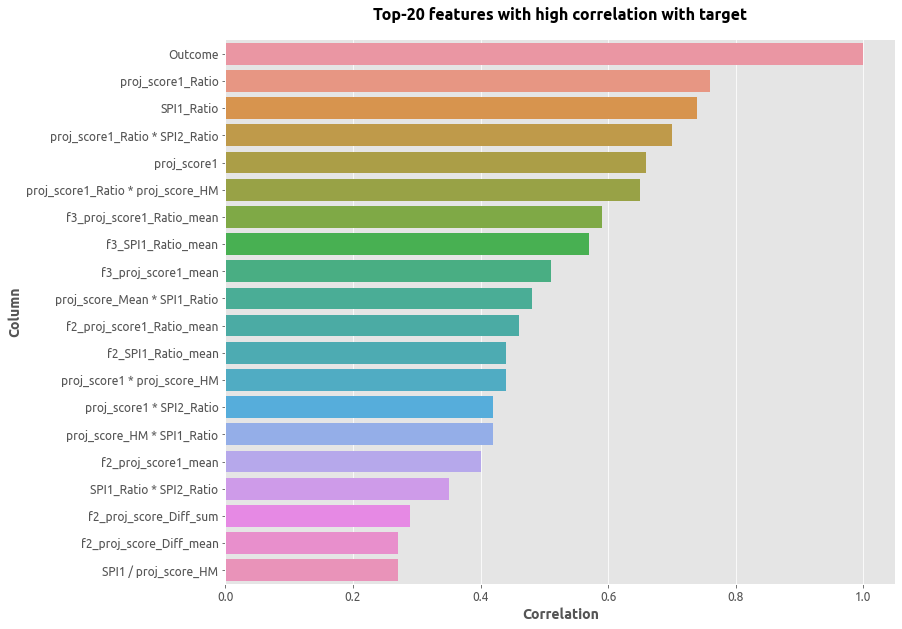

In [58]:
corr_list = []
for col in train_df.columns:
    corr = train_df[col].corr(train_df['Outcome'])
    corr_list.append([col, corr])

df = pd.DataFrame(corr_list, columns=['Column','Correlation'])
df['Correlation'] = np.round(df['Correlation'], 2)
df = df.sort_values(by='Correlation', ascending=False).head(20).copy()

plt.figure(figsize=(12, 10))
sns.barplot(x='Correlation', y='Column', data=df)
plt.title("Top-20 features with high correlation with target", pad=20);

## Save the processed datasets

In [59]:
data_dict = {}
data_dict['train_df'] = train_df
data_dict['test_df'] = test_df

file = open("./MH_Processed_Data.txt", 'wb')
pickle.dump(data_dict, file)
file.close()